In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
                        
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('hourly_energy_consumption/PJME_hourly.csv')

# **1. Data Visualization**

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


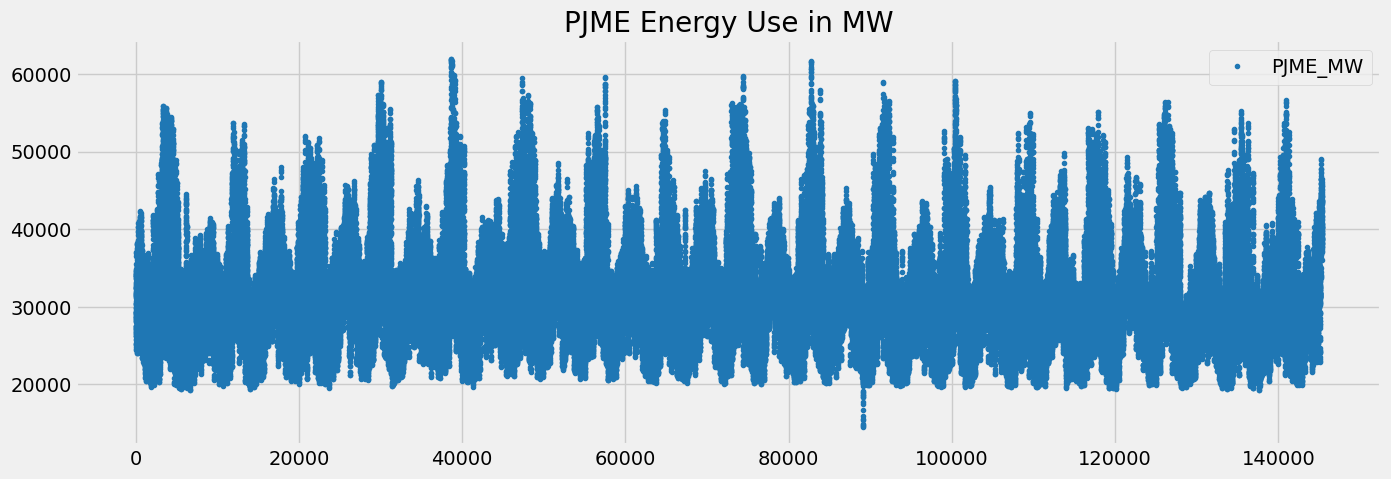

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# **2. Data Preprocessing**

Since this is a TimeSeries problem, we have to parse the 'datetime' column

In [5]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## 2.1 Handle Missings

In [6]:
df.isna().sum()

PJME_MW    0
dtype: int64

## 2.2 Handle Outliers

<Axes: ylabel='Frequency'>

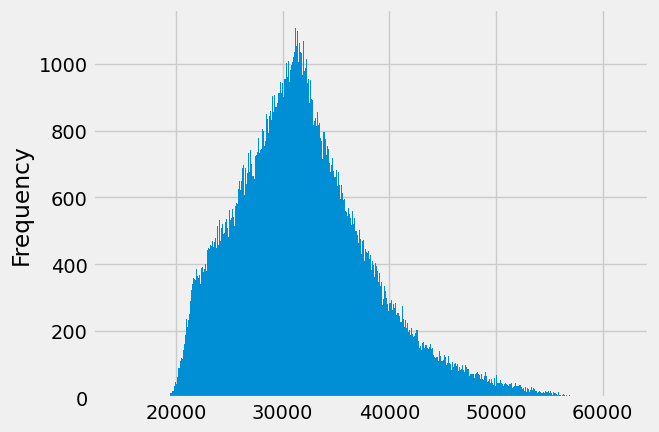

In [7]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

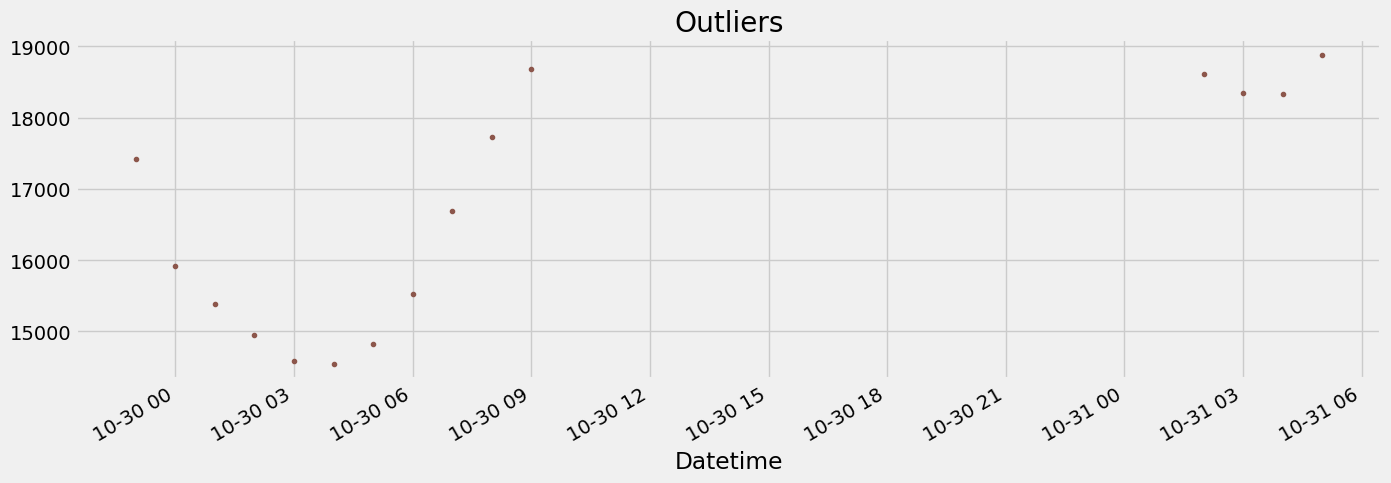

In [8]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [9]:
df = df.query('PJME_MW > 19_000').copy()

# **3. Feature Engineering**

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['season'] = df['month'] % 12 // 3 + 1
    return df

season_names = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Fall"
}

df = create_features(df)
df['season'] = df['season'].map(season_names)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,Winter
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,Winter
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,Winter
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,Winter
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,Winter


# **4. Exploratory Data Analysis**

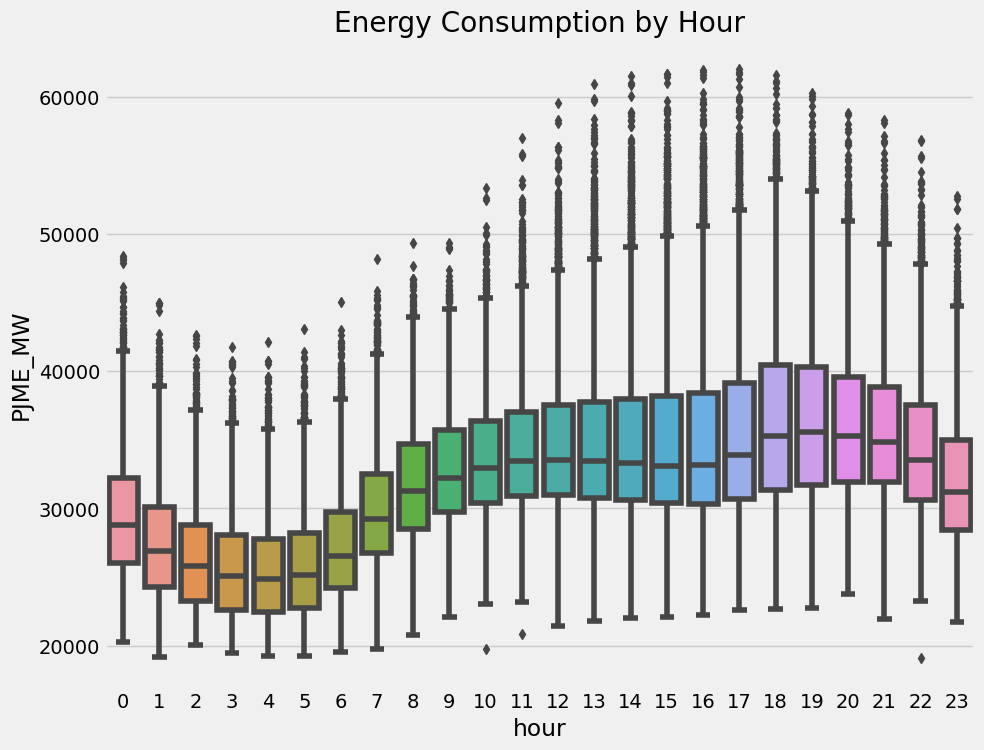

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Energy Consumption by Hour')
plt.show()

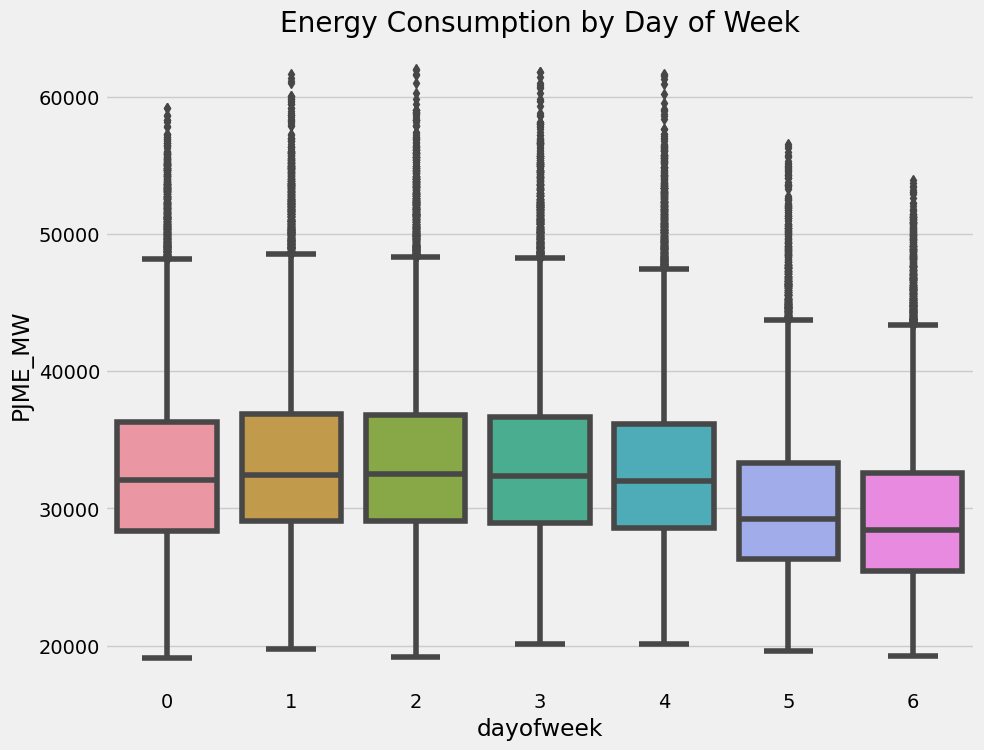

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')
ax.set_title('Energy Consumption by Day of Week')
plt.show()

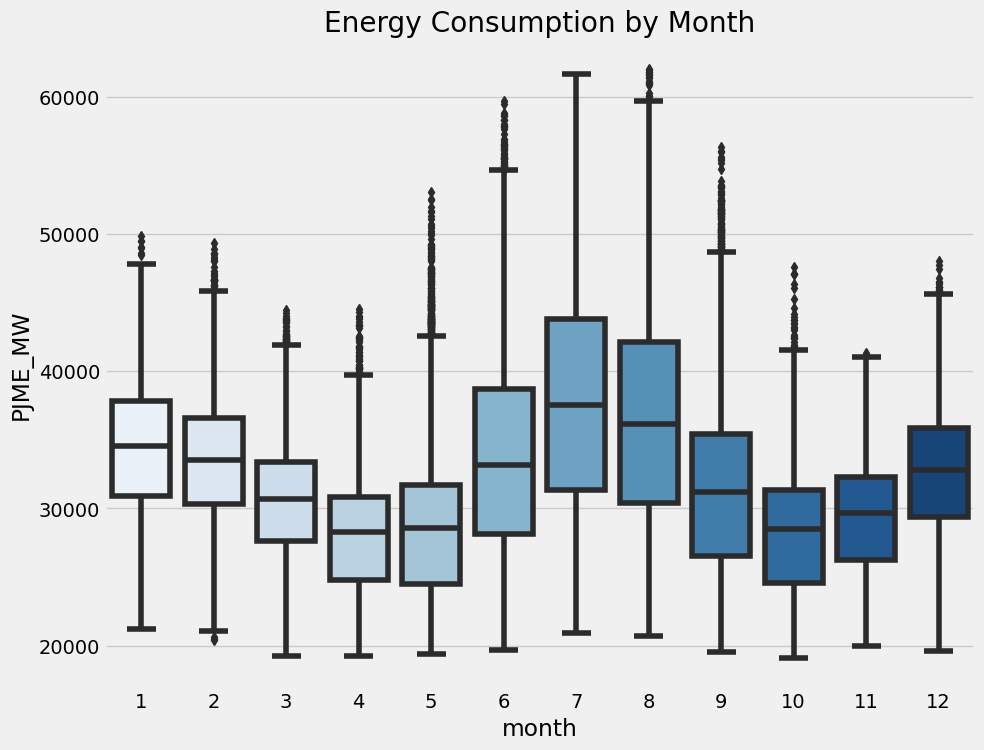

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('Energy Consumption by Month')
plt.show()

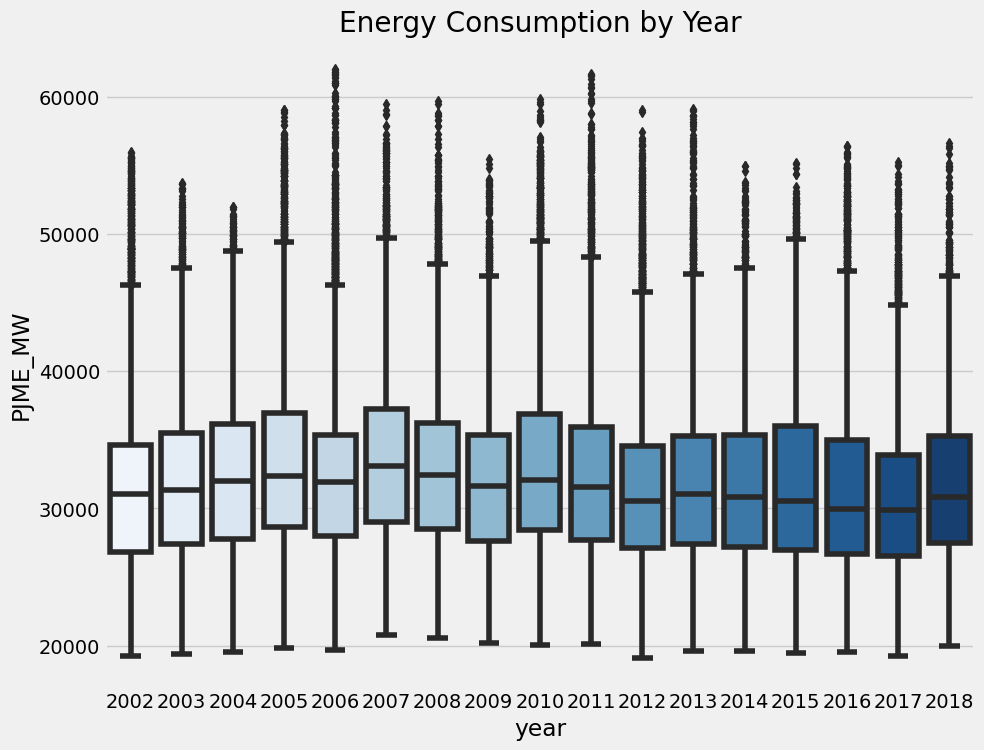

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='PJME_MW', palette='Blues')
ax.set_title('Energy Consumption by Year')
plt.show()

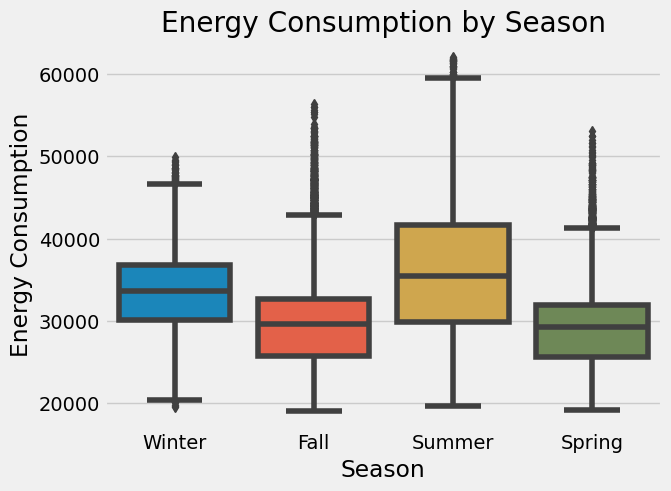

In [15]:
# Create a boxplot of energy consumption by season
sns.boxplot(x="season", y="PJME_MW", data=df)

# Set the plot title and axis labels
plt.title("Energy Consumption by Season")
plt.xlabel("Season")
plt.ylabel("Energy Consumption")

# Display the plot
plt.show()

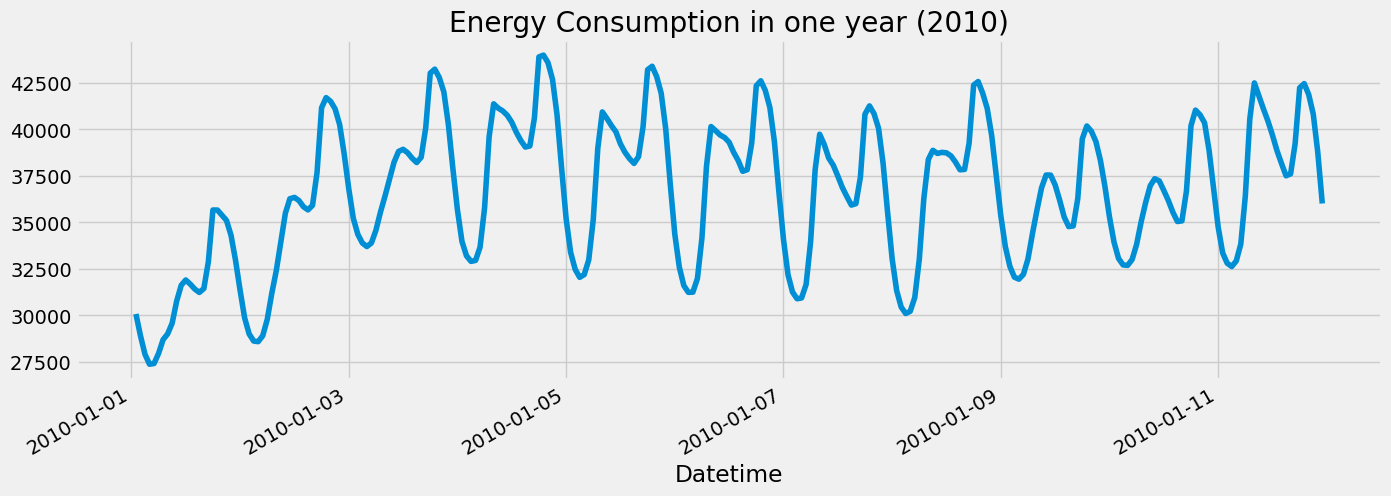

In [16]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-12')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Energy Consumption in one year (2010)')

plt.show()

- Our data has seasonality.
- Daily peak/highest is around 6 PM and the mininum is at 4 AM
- Least energy consumption on weekends (Saturday/Sunday)
- The highest energy consumption in a year is either in the end of the year or in the middle of the year
- No significant trend or change in total energy consumption throughout the year 2002-2018
- Highest energy consumption in summer, then winter

# **5. Modeling Univariate Time Series**

In [17]:
univariate_df = df[['PJME_MW']]
univariate_df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Resample Data (Downsampling)

In [18]:
# Resample to daily frequency
univariate_df = univariate_df.resample('D').sum()
univariate_df.head()

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


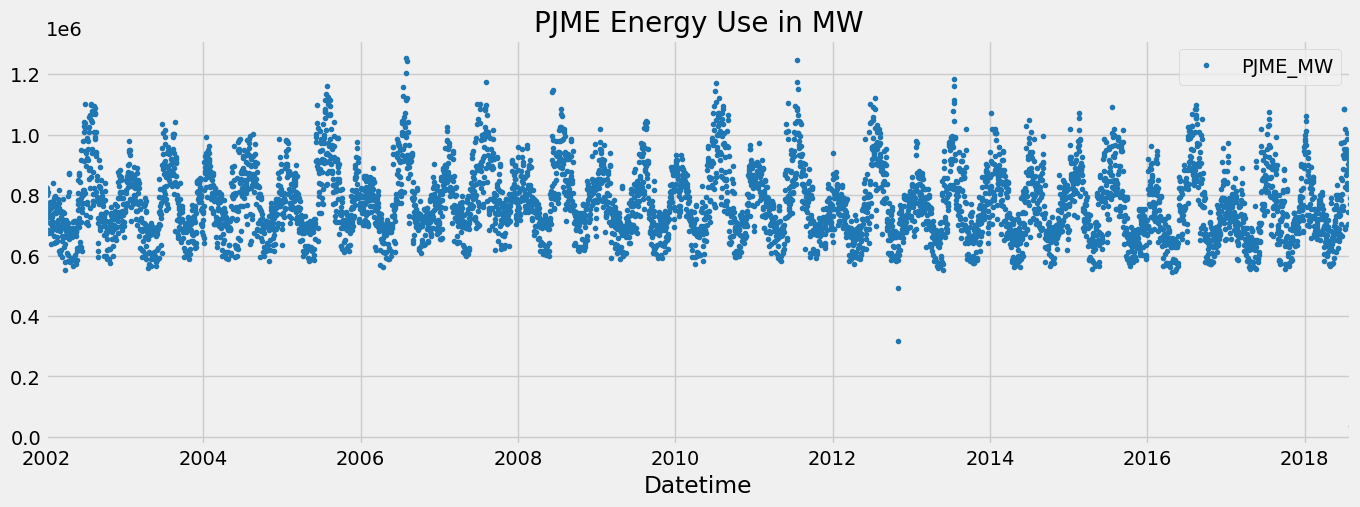

In [19]:
univariate_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

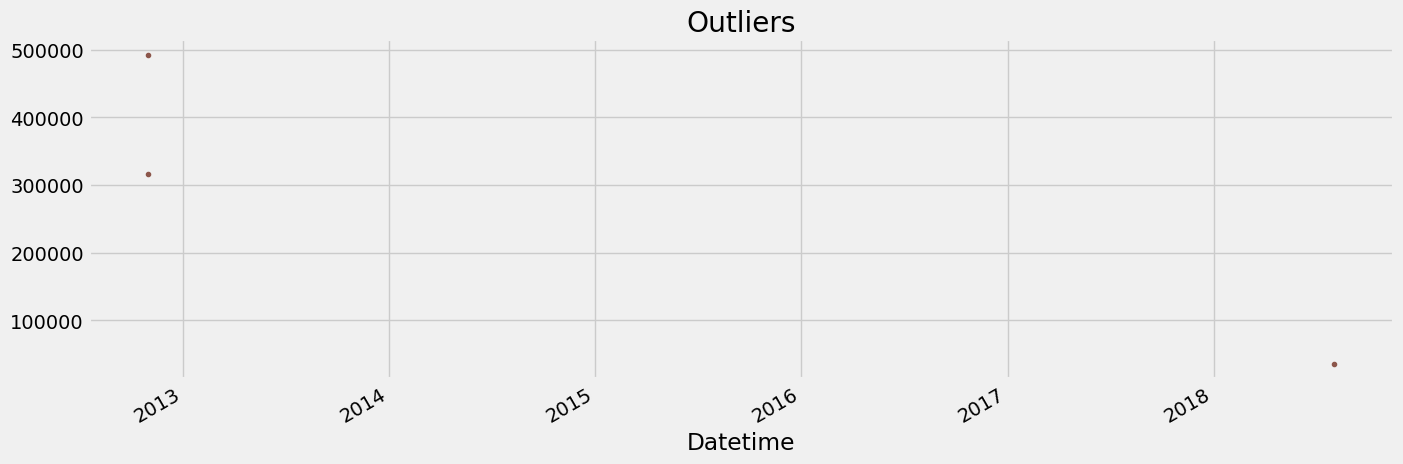

In [20]:
univariate_df.query('PJME_MW < 500_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [21]:
univariate_df = univariate_df.query('PJME_MW > 500_000').copy()

## Divide Data into Train / Test

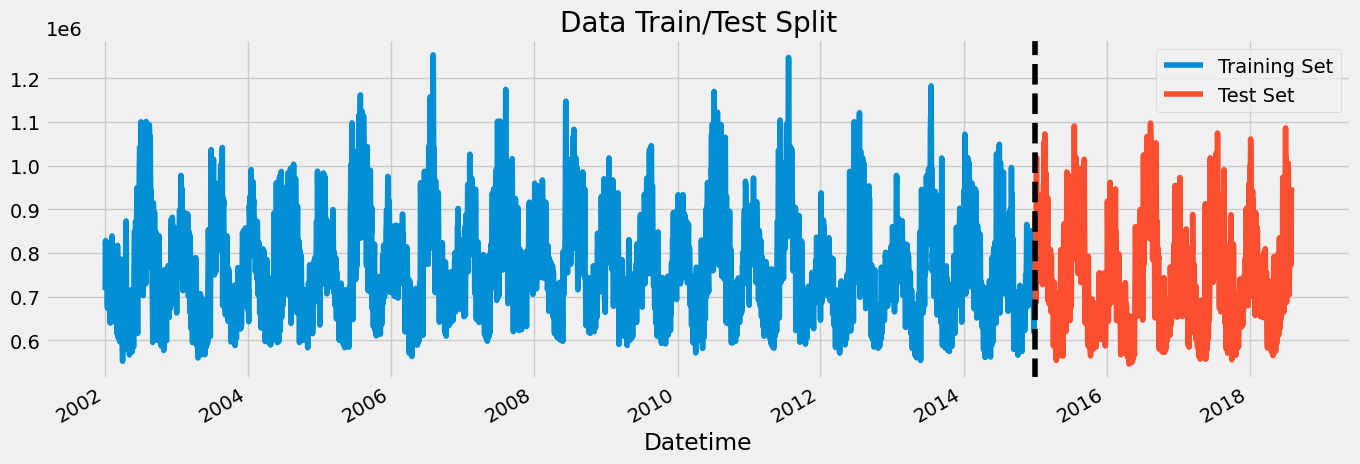

In [22]:
train = univariate_df.loc[univariate_df.index < '2015-01-01']
test = univariate_df.loc[univariate_df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 5.1 ARIMA

## Steps to analyze ARIMA
- **Check stationarity**: Determine if the time series has a trend or seasonality. If present, make it stationary before using ARIMA for forecasting.
- **Difference**: If the time series is not stationary, apply differencing to make it stationary. Take the first difference and check for stationarity. Repeat if necessary, including seasonal differencing.
- **Split validation sample**: Set aside a portion of the data for validation to assess the model's accuracy. Use a train-test validation split.
- **Select AR and MA terms**: Analyze the autocorrelation function (ACF) and partial autocorrelation function (PACF) to determine the inclusion of AR terms, MA terms, or both in the model.
- **Build the model**: Construct the ARIMA model and specify the number of periods to forecast (N) based on your requirements.
- **Validate the model**: Compare the predicted values with the actual values in the validation sample.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima

## Decompose time series to check for seasonality and trend

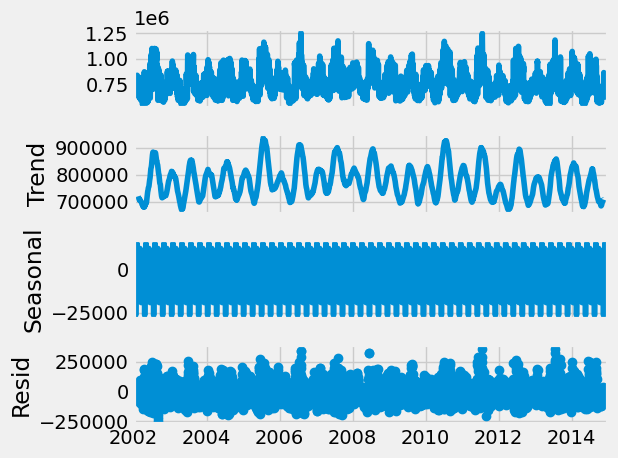

In [24]:
# Decompose time series
decompose = seasonal_decompose(train, model='additive', period=90)
decompose.plot()
plt.show()

### Very high seasonality!

## Check if the time series is stationary (Dickey-Fuller test)

In [25]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()


    # Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    plt.plot(timeseries, color=color_pal[0], label='Original')
    plt.plot(rolmean, color=color_pal[1], label='Rolling Mean')
    plt.plot(rolstd, color=color_pal[2], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # Extract and store the test statistics and critical values in a pandas Series
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    # Iterate over the critical values and add them to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

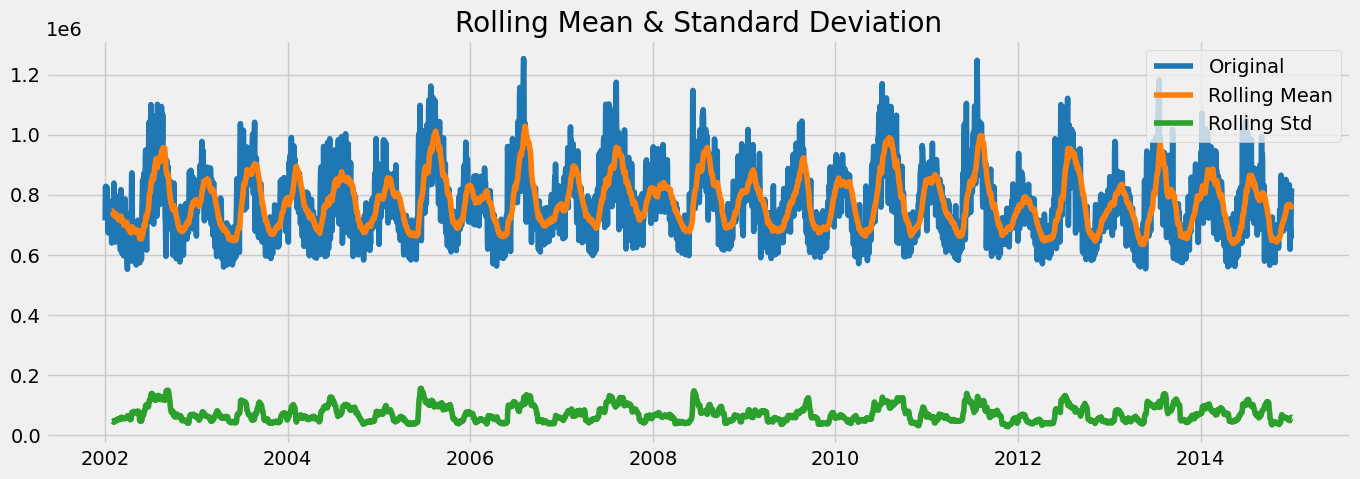

Results of Dickey-Fuller Test:
Test Statistic                -8.136183e+00
p-value                        1.057714e-12
#Lags Used                     3.000000e+01
Number of Observations Used    4.715000e+03
Critical Value (1%)           -3.431738e+00
Critical Value (5%)           -2.862153e+00
Critical Value (10%)          -2.567096e+00
dtype: float64


In [26]:
test_stationarity(train)

We use a rolling mean and standard deviation of 30 days and plot these along with the original time series. If the rolling statistics do not change over time, it is an indication that the time series is stationary. We also perform the Dickey-Fuller test and check if the p-value is less than 0.05. If it is, we can reject the null hypothesis that the time series is non-stationary.

Based on the results of the Dickey-Fuller test, the p-value is less than 0.05, and we can reject the null hypothesis. Therefore, the time series is stationary.

## Plot the ACF and PACF (Select AR and MA terms)

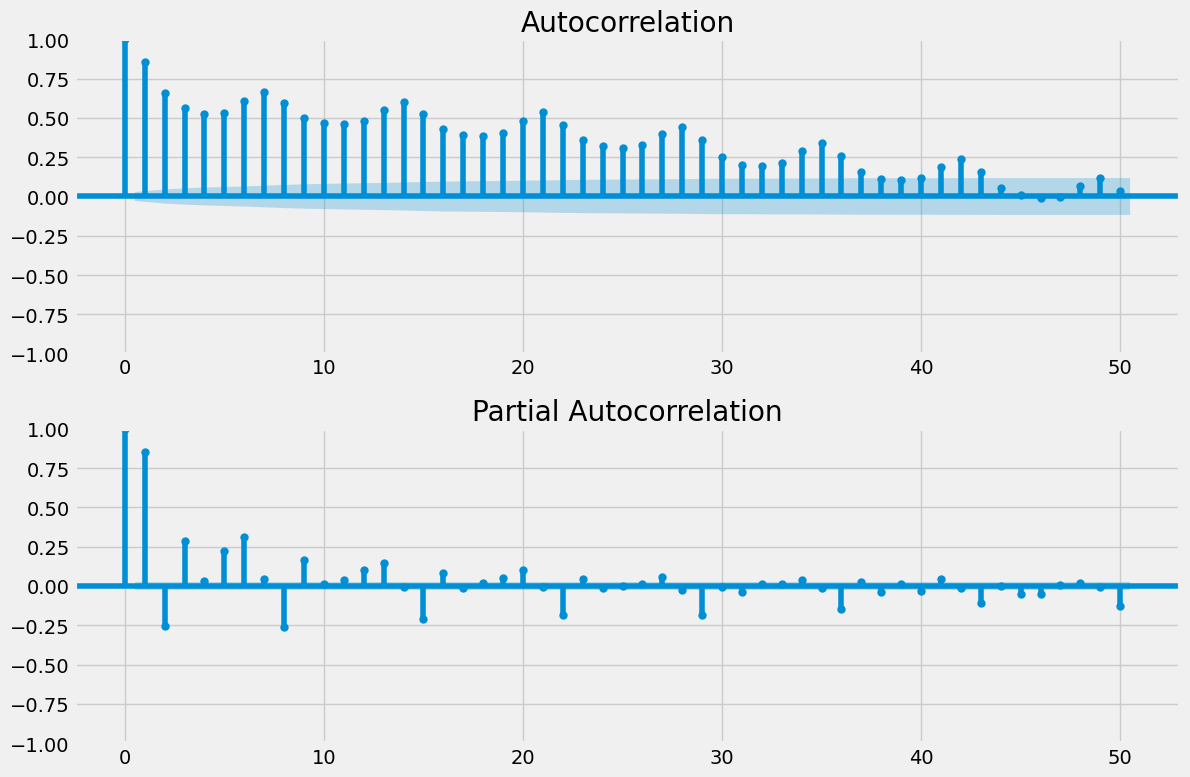

In [27]:
# ACF and PACF plots:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot ACF
plot_acf(train, lags=50, ax=ax1)

# Plot PACF
plot_pacf(train, lags=50, ax=ax2)

plt.tight_layout()
plt.show()

## Build the Model

In [28]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, 
           start_p=0, start_q=0, max_p=10, max_q=10, 
           seasonal=True, m=7,
           d=None, D=None, trace=True, 
           error_action='ignore', suppress_warnings=True, 
           stepwise=True, seasonal_test='ch')

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=120788.692, Time=2.21 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=121612.195, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=116466.107, Time=1.59 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=117453.791, Time=1.23 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=121610.205, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=117605.492, Time=0.44 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=116101.809, Time=3.32 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=115627.559, Time=2.76 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=115626.669, Time=1.85 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=115627.624, Time=3.38 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=115630.172, Time=4.10 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=120791.333, Time=1.02 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=115249.573, Time=2.30 sec
 ARIMA(2,0,0

In [28]:
# Fit the model
model = SARIMAX(train, 
                order=(2, 0, 0),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False, 
                enforce_invertibility=False)

result = model.fit()
result.summary()

/Users/julianivanov/opt/anaconda3/envs/time-series-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/julianivanov/opt/anaconda3/envs/time-series-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21696D+01    |proj g|=  1.06960D-01

At iterate    5    f=  1.21308D+01    |proj g|=  7.21968D-02

At iterate   10    f=  1.21268D+01    |proj g|=  2.30154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   6.064D-06   1.213D+01
  F =   12.126801201334944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             PJME_MW   No. Observations:                 4746
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood              -57553.799
Date:                             Sun, 11 Jun 2023   AIC                         115117.597
Time:                                     12:52:16   BIC                         115149.905
Sample:                                          0   HQIC                        115128.952
                                            - 4746                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0761      0.017     62.692      0.000       1.042       1.110
ar.L2         -0.2579      0.017    -15.384      0.000      -0.291      -0.225
ar.S.L7       -0.0607      0.024     -2.575      0.010      -0.107      -0.015
ma.S.L7       -0.6973      0.010    -67.320      0.000      -0.718      -0.677
sigma2      3.033e+09   4.71e-13   6.44e+21      0.000    3.03e+09    3.03e+09
===================================================================================
Ljung-Box (L1) (Q):                   7.50   Jarque-Bera (JB):              1232.05
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.00
Prob(H) (two-sided):                  0.35   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+37. Standard errors may be unstable.
"""

## Predict

In [29]:
# Convert the datetime index of test data to numeric index
test_numeric_index = range(len(test))

# Predict using SARIMAX model
predictions = result.predict(start=test_numeric_index[0], end=test_numeric_index[-1])

# Assign the converted numeric index to predictions
predictions.index = test.index

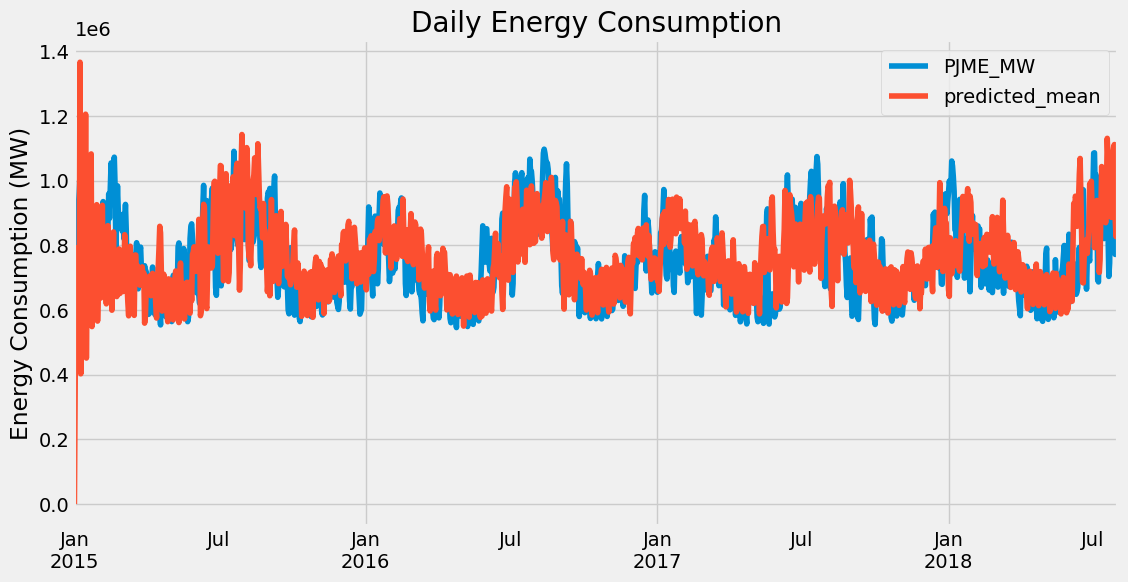

In [33]:
# Plot predictions against actual values
title = 'Daily Energy Consumption'
ylabel='Energy Consumption (MW)'
xlabel='' 

ax = test['PJME_MW'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.show()

## ARIMA Score:

In [163]:
# Calculate RMSE
arima_rmse = mean_squared_error(test['PJME_MW'], predictions, squared=False).round(2)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

arima_mape = mean_absolute_percentage_error(test['PJME_MW'], predictions).round(2)

print("ARIMA RMSE:", arima_rmse)
print(f"ARIMA MAPE {arima_mape}%")

ARIMA RMSE: 126971.22
ARIMA MAPE 13.22%


In [200]:
comparison = pd.concat([test, predictions], axis=1)
comparison_rounded = comparison.round(2)
comparison_rounded.columns = ['Actual', 'Predicted']
comparison_rounded.head()

,Actual,Predicted
Datetime,,
2015-01-01,762374.0,0.00
2015-01-02,771388.0,384624.13
2015-01-03,768345.0,792491.92
2015-01-04,685015.0,679277.27
2015-01-05,796227.0,657083.50


We actually have some missing data in the dataset. These are not NaN-Values, but rather just dates that were cut out. Due to the lack of data in 2014 the SARIMA model has some problems with predicting the first couple of values.  To fix this the dates that were cut out can be reconstructed. This would improve the quality of the data.

# 5.2 Prophet
Prophet uses an additive regression model, which means it represents a time series as a combination of components. The main components are: trend, seasonality, holidays and error

The model equation for Prophet is: y(t) = g(t) + s(t) + h(t) + e(t)

The model is fit using a method called Bayesian inference.


## Prepare data so Prophet can understand it

In [22]:
from prophet import Prophet

# Format data for prophet model using ds and y
pjme_train_prophet = train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

/Users/julianivanov/opt/anaconda3/envs/time-series-forecasting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Build Model

In [23]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

13:33:39 - cmdstanpy - INFO - Chain [1] start processing
13:33:39 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 244 ms, sys: 35.9 ms, total: 280 ms
Wall time: 1.1 s


## Predict

In [24]:
# Predict on test set with model
pjme_test_prophet = test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [25]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,750682.300680,694102.588900,861558.978293,750682.300680,750682.300680,29091.592770,29091.592770,29091.592770,26001.376405,26001.376405,26001.376405,3090.216365,3090.216365,3090.216365,0.0,0.0,0.0,779773.893450
1,2015-01-02,750668.150122,685047.521700,861462.282818,750668.150122,750668.150122,18616.442108,18616.442108,18616.442108,14451.923075,14451.923075,14451.923075,4164.519033,4164.519033,4164.519033,0.0,0.0,0.0,769284.592230
2,2015-01-03,750653.999564,621716.635003,797989.837066,750653.999564,750653.999564,-42211.225805,-42211.225805,-42211.225805,-48032.825019,-48032.825019,-48032.825019,5821.599213,5821.599213,5821.599213,0.0,0.0,0.0,708442.773759
3,2015-01-04,750639.849006,602983.010679,782559.727663,750639.849006,750639.849006,-59331.125986,-59331.125986,-59331.125986,-67377.234666,-67377.234666,-67377.234666,8046.108680,8046.108680,8046.108680,0.0,0.0,0.0,691308.723020
4,2015-01-05,750625.698448,689304.899458,860835.802621,750625.698448,750625.698448,25531.080914,25531.080914,25531.080914,14721.631329,14721.631329,14721.631329,10809.449584,10809.449584,10809.449584,0.0,0.0,0.0,776156.779362


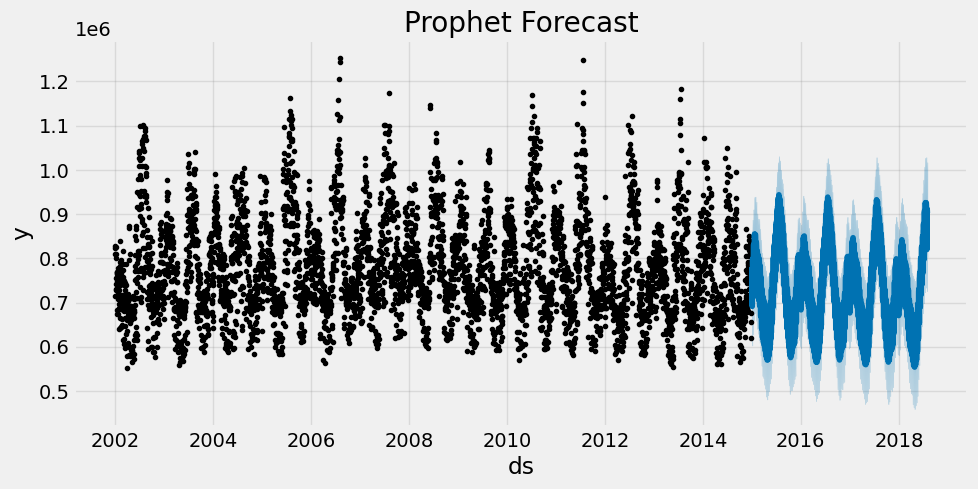

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

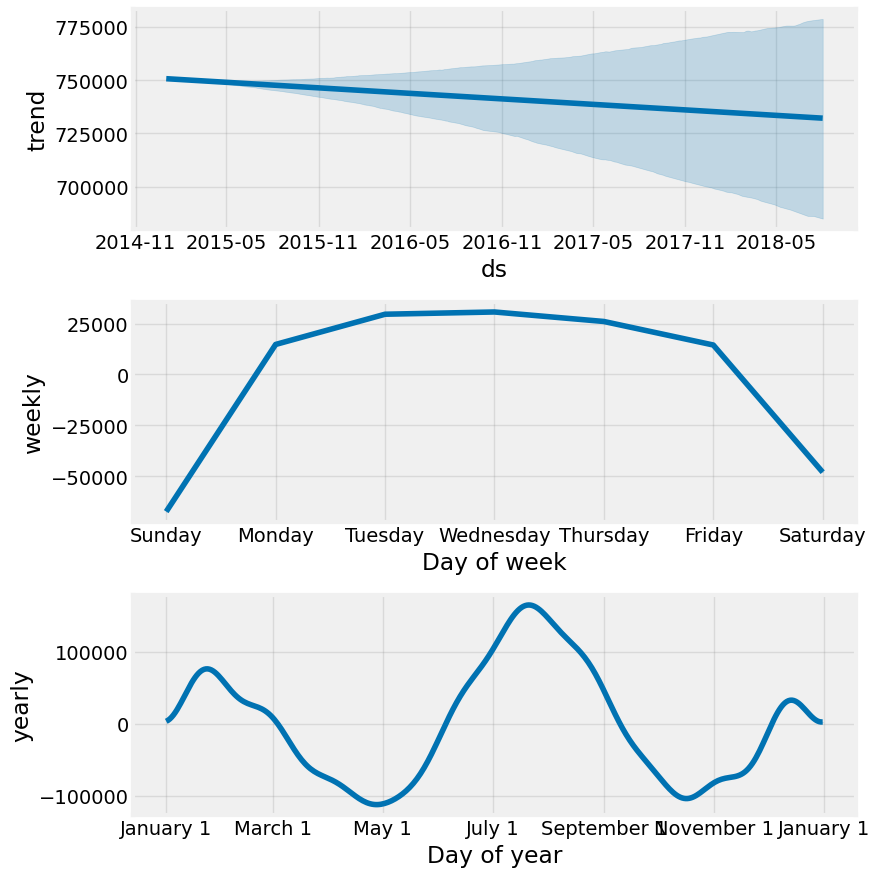

In [27]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## Compare Forecast to Actuals

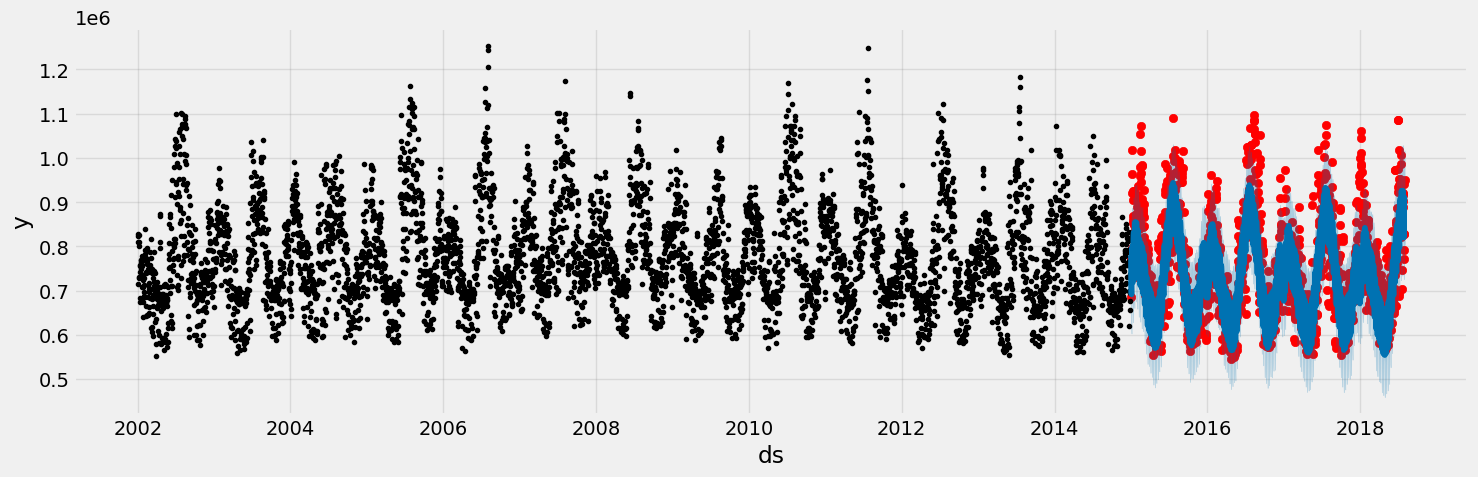

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

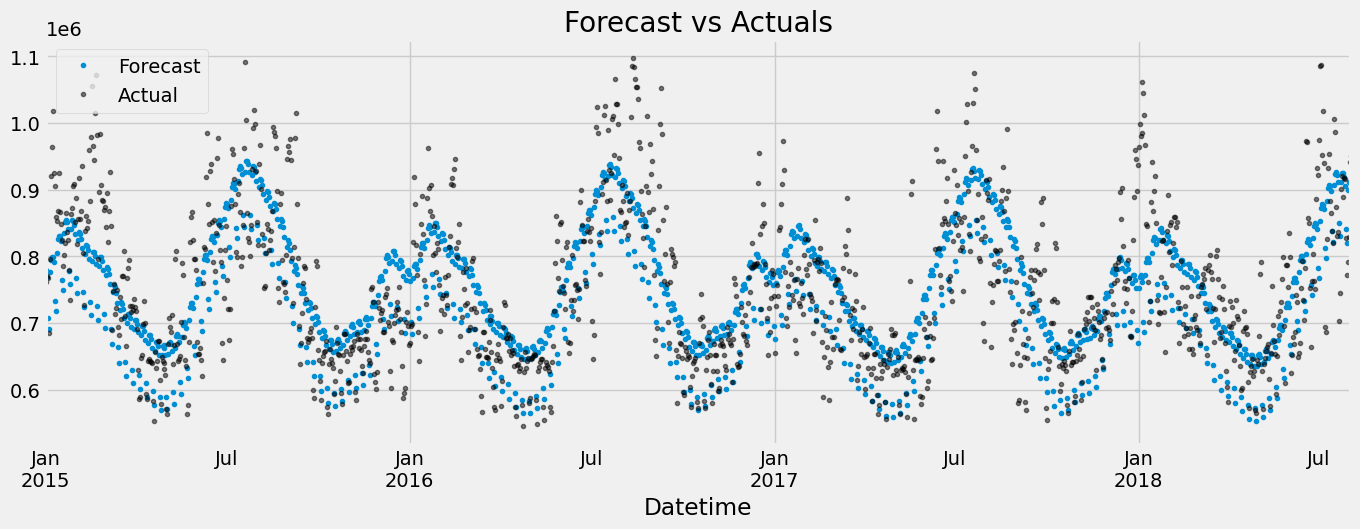

In [29]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=1,
                          alpha=0.5,
                          color = "black")

plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

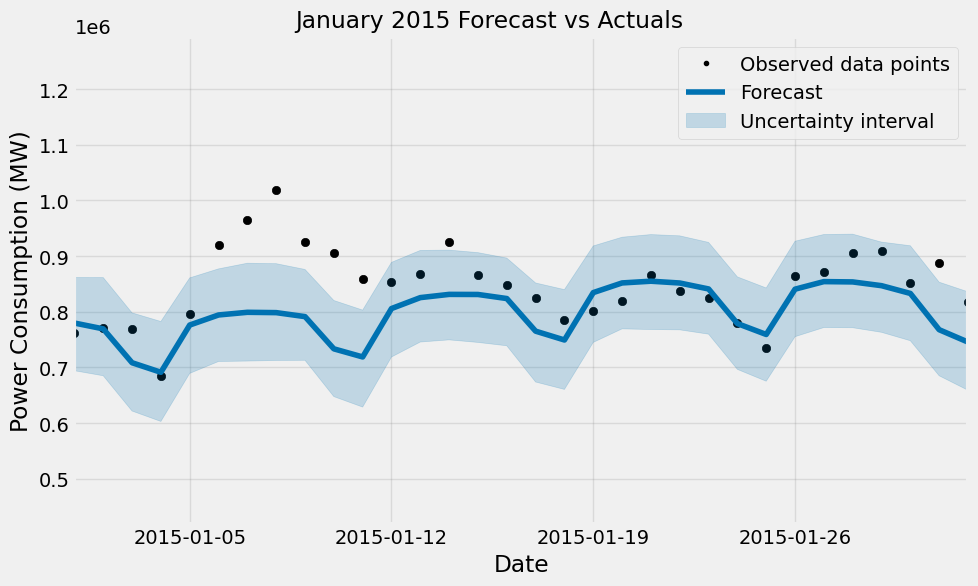

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(test.index, test['PJME_MW'], color='black')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption (MW)')
plot = plt.suptitle('January 2015 Forecast vs Actuals')

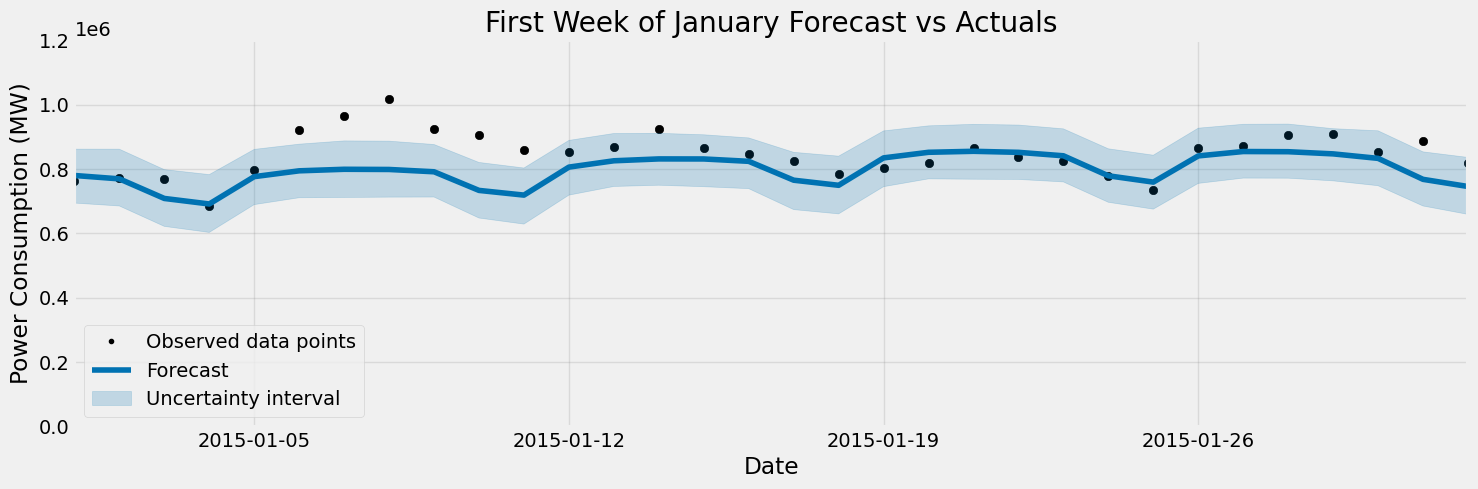

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['PJME_MW'], color='black')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 1200000)
ax.set_title('First Week of January Forecast vs Actuals')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption (MW)')
plt.show()

## Prophet Score

In [32]:
# Calculate RMSE
prophet_rmse = mean_squared_error(y_true=test['PJME_MW'], y_pred=pjme_test_fcst['yhat'], squared=False).round(2)

# Calculate MAPE
def prophet_mape(y_true, y_pred):
    y_true = np.array(y_true)  # Convert y_true to a numpy array if it's not already
    y_pred = np.array(y_pred)  # Convert y_pred to a numpy array if it's not already

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Convert 'test['PJME_MW']' and 'pjme_test_fcst['yhat']' to appropriate values for MAPE calculation
y_true_mape = test['PJME_MW'].values
y_pred_mape = pjme_test_fcst['yhat'].values

prophet_mape = prophet_mape(y_true_mape, y_pred_mape).round(2)

print("Prophet RMSE:", prophet_rmse)
print(f"Prophet MAPE: {prophet_mape}%")


Prophet RMSE: 78333.89
Prophet MAPE: 7.48%


## Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [33]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Create an instance of the USFederalHolidayCalendar
cal = calendar()

# Get the holidays within the specified date range for the training set
train_holidays = cal.holidays(start=train.index.min(), end=train.index.max())

# Get the holidays within the specified date range for the test set
test_holidays = cal.holidays(start=test.index.min(), end=test.index.max())

In [35]:
# Create a new DataFrame with 'date' and 'is_holiday' columns
univariate_df['date'] = univariate_df.index.date
univariate_df['is_holiday'] = univariate_df.date.isin([d.date() for d in cal.holidays()])

# Filter the DataFrame to include only the rows with holidays
holiday_df = univariate_df.loc[univariate_df['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})

# Add a new column 'holiday' and set its value to 'USFederalHoliday' for all rows in holiday_df
holiday_df['holiday'] = 'USFederalHoliday'

# Drop unnecessary columns from holiday_df
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)

# Convert the 'ds' column in holiday_df to datetime format
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

# Set up and train the Prophet model with the holidays specified
model_with_holidays = Prophet(holidays=holiday_df)

# Fit the model to the training data, renaming the 'Datetime' and 'PJME_MW' columns to 'ds' and 'y'
model_with_holidays.fit(train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

holiday_df.head()

13:35:37 - cmdstanpy - INFO - Chain [1] start processing
13:35:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,holiday
0,2002-01-01,USFederalHoliday
1,2002-01-21,USFederalHoliday
2,2002-02-18,USFederalHoliday
3,2002-05-27,USFederalHoliday
4,2002-07-04,USFederalHoliday


In [36]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [37]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

13:35:51 - cmdstanpy - INFO - Chain [1] start processing
13:35:52 - cmdstanpy - INFO - Chain [1] done processing


## Predict with Holidays

In [38]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

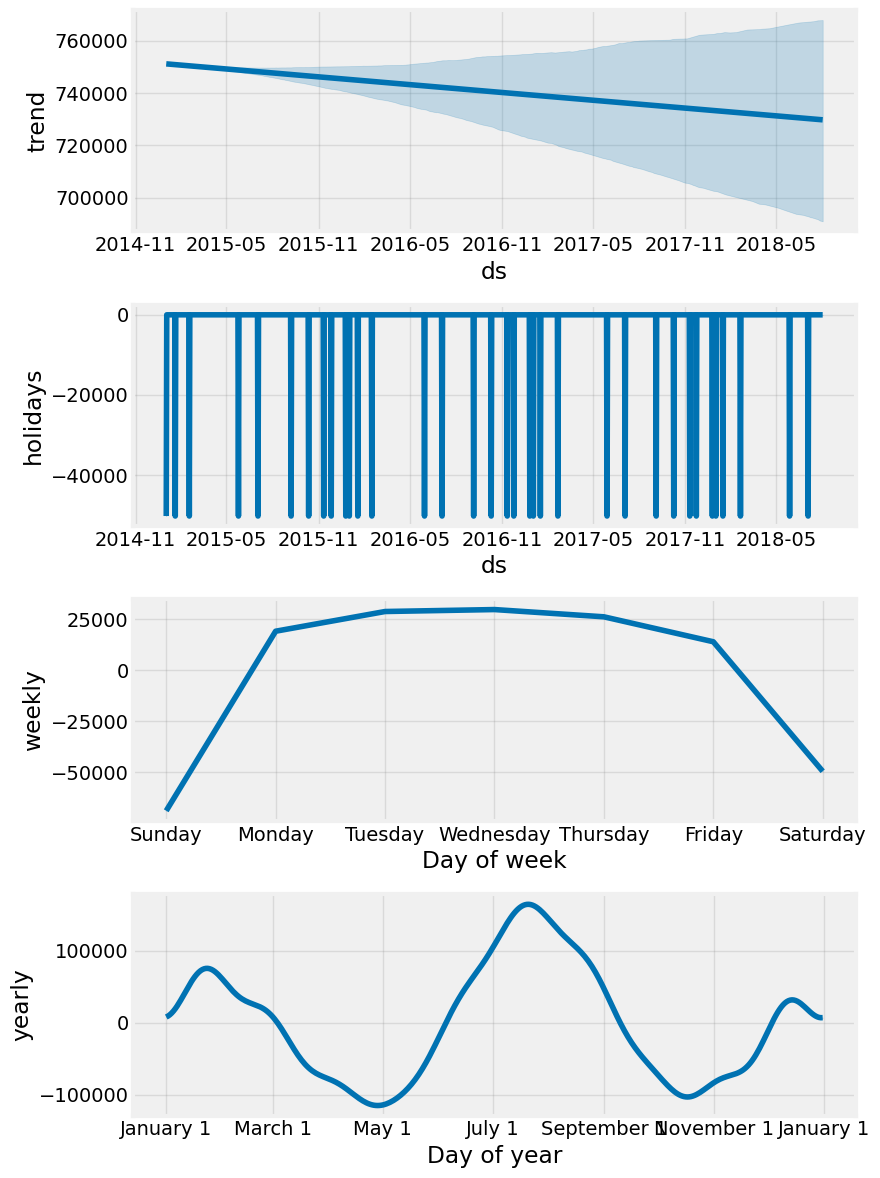

In [39]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

## Prophet Score with Holidays:

In [40]:
prophet_rmse_holidays = mean_squared_error(y_true=test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'], squared=False).round(2)
print(f"RMSE with holidays: {prophet_rmse_holidays}")
print(f"RMSE without holidays: {prophet_rmse}")

RMSE with holidays: 78439.56
RMSE without holidays: 78333.89


In [41]:
# Assign the date component of the 'ds' column to the 'date' column in holiday_df
holiday_df['date'] = holiday_df['ds'].dt.date

# Group holiday_df by the 'date' column
for hol, d in holiday_df.groupby('date'):
    # Get the list of holidays for the current date
    holiday_list = d['ds'].tolist()
    
    # Filter the test set to include only rows with dates in the holiday_list
    hols_test = test.query('Datetime in @holiday_list')
    
    # Skip to the next iteration if there are no rows in hols_test
    if len(hols_test) == 0:
        continue
    
    # Filter the predicted test set to include only rows with dates in the holiday_list
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    
    # Filter the predicted test set with holiday model to include only rows with dates in the holiday_list
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    
    # Calculate the mean absolute error (MAE) for non-holiday model predictions
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'], y_pred=hols_pred['yhat'])
    
    # Calculate the mean absolute error (MAE) for holiday model predictions
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'], y_pred=hols_pred_holiday_model['yhat'])
    
    # Calculate the difference in MAE between the non-holiday model and holiday model
    diff = non_hol_error - hol_model_error
    
    # Print the results for the current holiday
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')


Holiday: January 01, 2015:    
 MAE (non-holiday model): 17399.9 
 MAE (Holiday Model): 27482.0 
 Diff -10082.1
Holiday: January 19, 2015:    
 MAE (non-holiday model): 32181.0 
 MAE (Holiday Model): 13451.0 
 Diff 18730.0
Holiday: February 16, 2015:    
 MAE (non-holiday model): 262072.8 
 MAE (Holiday Model): 306742.1 
 Diff -44669.3
Holiday: May 25, 2015:    
 MAE (non-holiday model): 32165.1 
 MAE (Holiday Model): 11919.8 
 Diff 20245.3
Holiday: July 03, 2015:    
 MAE (non-holiday model): 151320.6 
 MAE (Holiday Model): 101843.9 
 Diff 49476.8
Holiday: September 07, 2015:    
 MAE (non-holiday model): 36285.5 
 MAE (Holiday Model): 80999.0 
 Diff -44713.6
Holiday: October 12, 2015:    
 MAE (non-holiday model): 22194.8 
 MAE (Holiday Model): 22118.0 
 Diff 76.8
Holiday: November 11, 2015:    
 MAE (non-holiday model): 39428.9 
 MAE (Holiday Model): 10184.4 
 Diff 29244.5
Holiday: November 26, 2015:    
 MAE (non-holiday model): 107996.6 
 MAE (Holiday Model): 60193.9 
 Diff 47802.

## Extra: Use built in function to predict
We can use the built in make_future_dataframe method to build our future dataframe and make predictions.

In [186]:
future = model.make_future_dataframe(periods=365*24*5, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [187]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2014-12-31 01:00:00,788527.233683
1,2014-12-31 02:00:00,788875.012738
2,2014-12-31 03:00:00,789185.676842
3,2014-12-31 04:00:00,789453.937041
4,2014-12-31 05:00:00,789675.298338


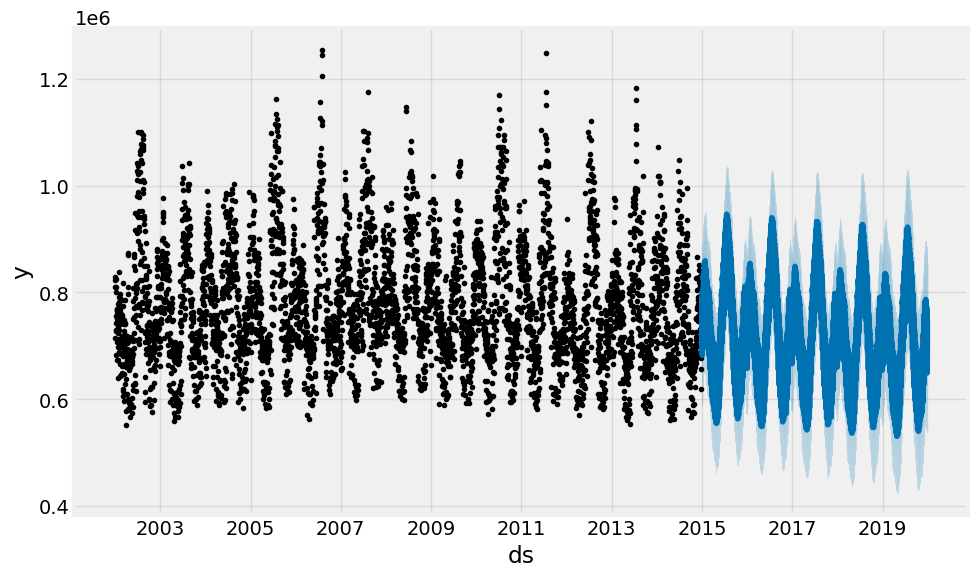

In [188]:
fig = model_with_holidays.plot(forecast)
plt.show()

# 5.3 LSTM

## Prepare Data for LSTM

In [189]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)  # Scale the training data between 0 and 1

# Create the training data
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(scaled_train[i-60:i, 0])  # Create sequences of 60 previous values as input (lookback period)
    y_train.append(scaled_train[i, 0])  # Current value as output
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Reshape the input data to be 3-dimensional (samples, timesteps, features) for LSTM model

## Build the Model (inlcuding Hyperparamter Tuning)

In [190]:
import shutil

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                          return_sequences=True, 
                          input_shape=(X_train.shape[1], 1)))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                          return_sequences=False))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Clear the tuner directory
#shutil.rmtree('project/Energy Consumption LSTM')

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # how many model configurations would you like to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory='project',
    project_name='Energy Consumption LSTM')

# Summary of the search space
tuner.search_space_summary()

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

# Summary of the results
tuner.results_summary()

INFO:tensorflow:Reloading Tuner from project/Energy Consumption LSTM/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
INFO:tensorflow:Oracle triggered exit
Results summary
Results in project/Energy Consumption LSTM
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
units: 64
dropout: 0.1
Score: 0.00956764662017425

Trial 4 summary
Hyperparameters:
units: 128
dropout: 0.4
Score: 0.009610474420090517

Trial 2 summary
Hyperparameters:
units: 128
dropout: 0.5
Score: 0.010451234877109528

Trial 1 summary
Hyperparameters:
units: 32
dropout: 0.1
Score: 0.011480971860388914

Trial 3 summary
Hyperparameters:
units: 64
dropout: 0.4
Score: 0.011589139079054197


In [191]:
from keras.callbacks import EarlyStopping

# Choose the best model
best_model = tuner.get_best_models(num_models=5)[3]

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history = best_model.fit(X_train, y_train, epochs = 50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 8s 40ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 2/50
118/118 [==============================] - 4s 33ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 3/50
118/118 [==============================] - 4s 33ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 4/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 5/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 6/50
118/118 [==============================] - 4s 33ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 8/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 9/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 10/50
118/118 [==============================] - 4s 34ms/step - loss: 0.0063 - val_lo

## Plot Validation Loss vs Training Loss

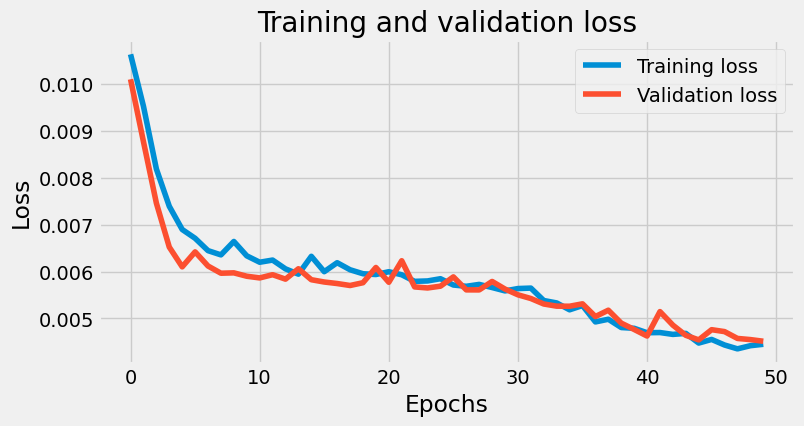

In [192]:
# Plot the training loss and validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict

In [193]:
# Prepare the test data similarly to the training data

# Get the inputs for the test data
inputs = univariate_df[len(univariate_df) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)  # Reshape the input data to have a single feature column

inputs = scaler.transform(inputs)  # Scale the test data using the same scaler used for training

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])  # Create sequences of 60 previous values as input for the test data (lookback period)
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Reshape the test data to be 3-dimensional (samples, timesteps, features) for LSTM model

/Users/julianivanov/opt/anaconda3/envs/time-series-forecasting/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [194]:
# Make predictions with the best model
predicted_energy_consumption = best_model.predict(X_test)

# Inverse transform to get real values
predicted_energy_consumption = scaler.inverse_transform(predicted_energy_consumption)

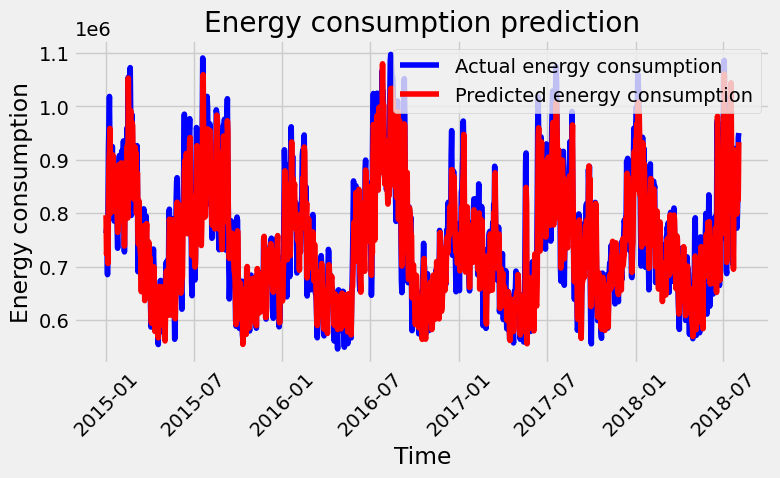

In [195]:
# Visualize the results
test_dates = univariate_df.index[len(univariate_df) - len(test):]
plt.figure(figsize=(8,4))
plt.plot(test_dates, test.values, color='blue', label='Actual energy consumption')
plt.plot(test_dates, predicted_energy_consumption.flatten(), color='red', label='Predicted energy consumption')
plt.title('Energy consumption prediction')
plt.xlabel('Time')
plt.ylabel('Energy consumption')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

## LSTM Score:

In [196]:
# Evaluate the Model
lstm_rmse = mean_squared_error(test.values, predicted_energy_consumption, squared=False).round(2)
lstm_mape = mean_absolute_percentage_error(test.values, predicted_energy_consumption).round(2)

print("LSTM RMSE:", lstm_rmse)
print(f"LSTM MAPE {lstm_mape}%")

LSTM RMSE: 48014.44
LSTM MAPE 4.71%


# 6. Comparison of Models

In [197]:
print(f"ARIMA RMSE: {arima_rmse}")
print(f"Prophet RMSE: {prophet_rmse}")
print(f"LSTM RMSE: {lstm_rmse}")
print("")
print(f"ARIMA MAPE: {arima_mape}%")
print(f"Prophet MAPE: {prophet_mape}%")
print(f"LSTM MAPE: {lstm_mape}%")

ARIMA RMSE: 126971.22
Prophet RMSE: 78333.89
LSTM RMSE: 48014.44

ARIMA MAPE: 13.22%
Prophet MAPE: 7.48%
LSTM MAPE: 4.71%


# Takeaways

### ARIMA (Autoregressive Integrated Moving Average):
ARIMA models are a staple in time series forecasting. They are designed to capture autocorrelation in the data, or in other words, the idea that future data points are related to past ones.

##### Advantages:

- simple and interpretable parameters
- less tuning needed compared to machine learning models

##### Disadvantages:

- requires stationary data
- struggles with multiple seasonal patterns
- computationally intensive for large datasets

### Prophet:
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

##### Advantages:

- handles multiple seasonalities well
- flexible with inclusion of holiday effects and additional regressors
- easy to use (does not require a deep understanding of its underlying implementations)

##### Disadvantages:

- components of the forecast are not easily interpretable as those in ARIMA
- less Effective on High Frequency Data (e.g., data collected every minute or every second)

### LSTM (Long Short-Term Memory):
LSTMs are a type of recurrent neural network that are capable of learning long-term dependencies, which makes them useful for time series forecasting.

##### Advantages:

- can model complex non-linear relationships (superior performance on many time series datasets)
- can learn long-term dependencies (beneficial when past observations are relevant to future forecasts)
- handles multiple seasonal patterns (like Prophet)

##### Disadvantages:

- can be slow to train, particularly on large datasets
- risk of overfitting without careful design and regularization
- forecasts difficult to interpret ('Black Box')
- equires larger amounts of data for training

**Remember**: No single model is the best for every type of time series data. The choice of model depends heavily on the characteristics of your data and what you prioritize in your forecasting task. For example, if interpretability is most important, you might lean towards ARIMA. If you are dealing with complex patterns and large amounts of data, LSTMs might be more appropriate. And for handling multiple seasonalities with a flexible and user-friendly model, Prophet could be your best choice.